In [1]:
# import packages
import sys
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# load the dataset
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [3]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255.0 # Normalizing between 0 to 1
Y = df.iloc[:,0].to_numpy()

In [4]:
# split into train and test data
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [5]:
# Shuffle the training data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [6]:
# Show PIC func
def showPIC(x,y):
    plt.figure(figsize=(2,2))
    plt.title("Digit: "+str(y))
    plt.imshow(x.reshape(28,28))
    plt.show()

<IPython.core.display.Javascript object>


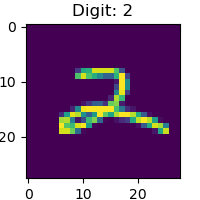

In [7]:
# Testing a PIC
pic_id = 1
showPIC(Xtrain[pic_id], Ytrain[pic_id])

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [10]:
def relu(z):
    return z*(z>0)

In [11]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

In [12]:
def oneHotEncode(y):
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))
    
    for i,val in enumerate(y):
        T[i,val] = 1
        
    return T

In [13]:
def nonlinearDr(z,activation):
    if activation=="sigmoid":
        return z*(1-z)
    if activation=="tanh":
        return (1-z**2)
    if activation=="relu":
        return (z>0)

In [14]:
def cost(t,y):
    return -np.sum(t*np.log(y))

In [15]:
def predict(yhat):
    return np.argmax(yhat, axis=1)

In [16]:
def forward(X,T,hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,i,seed):
    D = X.shape[1]
    K = T.shape[1]
    L = len(hidden)
    
    for l in range(L+1):
        if l==0:
            if i==0:
                W[l] = np.random.randn(D,hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = activation(np.dot(X,W[l])+B[l])
            
        elif l==L:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],K)
                B[l] = np.random.randn(K)
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = softmax(np.dot(A[l-1],W[l])+B[l])
            Y = A[l]
            
        else:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
                cache_W[l] = 0
                cache_B[l] = 0
            A[l] = activation(np.dot(A[l-1],W[l])+B[l])
    
    return W,B,A,Vw,Vb,cache_W,cache_B,Y

In [17]:
def backprop(X,T,Y,hidden,activation,lr,momentum,Nesterov,AdaGrad,RMSProp,Adam,decay,cache_W,cache_B,W,B,A,Vw,Vb,timestep):
    L = len(hidden)
    Err,Grad = {},{}
    
    for l in range(L,-1,-1):
        if l==L:
            Err[l] = T-Y
            Grad[l] = Err[l]
            
        else:
            Err[l] = np.dot(Grad[l+1],W[l+1].T)
            Grad[l] = Err[l]*nonlinearDr(A[l],activation.__name__)
            
    for l in range(L+1):
        if Adam:
            if l==0:
                gradW = np.dot(X.T,Grad[l])
                gradB = Grad[l].sum(axis=0)
                
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2 # RMSProp
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                
                correct_cache_W = cache_W[l] / (1 - decay ** timestep) # Bias Correction for Cache
                correct_cache_B = cache_B[l] / (1 - decay ** timestep) 
                
                Vw[l] = Vw[l] * momentum + (1 - momentum) * gradW # Momentum
                Vb[l] = Vb[l] * momentum + (1 - momentum) * gradB
                
                correct_moment_W = Vw[l] / (1 - momentum ** timestep) # Bias Correction for Momentum
                correct_moment_B = Vb[l] / (1 - momentum ** timestep)
                
                W[l] += lr * correct_moment_W / (np.sqrt(correct_cache_W) + 1e-8)
                B[l] += lr * correct_moment_B / (np.sqrt(correct_cache_B) + 1e-8)
            else:
                gradW = np.dot(A[l-1].T, Grad[l])
                gradB = Grad[l].sum(axis=0)
                
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2 # RMSProp
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                
                correct_cache_W = cache_W[l] / (1 - decay ** timestep) # Bias Correction for Cache
                correct_cache_B = cache_B[l] / (1 - decay ** timestep) 
                
                Vw[l] = Vw[l] * momentum + (1 - momentum) * gradW # Momentum
                Vb[l] = Vb[l] * momentum + (1 - momentum) * gradB
                
                correct_moment_W = Vw[l] / (1 - momentum ** timestep) # Bias Correction for Momentum
                correct_moment_B = Vb[l] / (1 - momentum ** timestep)
                
                W[l] += lr * correct_moment_W / (np.sqrt(correct_cache_W) + 1e-8)
                B[l] += lr * correct_moment_B / (np.sqrt(correct_cache_B) + 1e-8)
        elif AdaGrad:
            if l==0:
                gradW = np.dot(X.T,Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] += gradW ** 2
                cache_B[l] += gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
            else:
                gradW = np.dot(A[l-1].T, Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] += gradW ** 2
                cache_B[l] += gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
                
        elif RMSProp:
            if l==0:
                gradW = np.dot(X.T,Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
            else:
                gradW = np.dot(A[l-1].T, Grad[l])
                gradB = Grad[l].sum(axis=0)
                cache_W[l] = cache_W[l] * decay + (1 - decay) * gradW ** 2
                cache_B[l] = cache_B[l] * decay + (1 - decay) * gradB ** 2
                W[l] += lr * gradW / (np.sqrt(cache_W[l]) + 1e-8)
                B[l] += lr * gradB / (np.sqrt(cache_B[l]) + 1e-8)
                
        elif Nesterov:
            if l==0:
                Vw[l] = Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                B[l] += Vb[l] * momentum + lr * Grad[l].sum(axis=0)
            else:
                Vw[l] = Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                B[l] += Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                
        else:
            if l==0:
                Vw[l] = Vw[l] * momentum + lr * np.dot(X.T,Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l]
                B[l] += Vb[l]
            else:
                Vw[l] = Vw[l] * momentum + lr * np.dot(A[l-1].T, Grad[l])
                Vb[l] = Vb[l] * momentum + lr * Grad[l].sum(axis=0)
                W[l] += Vw[l]
                B[l] += Vb[l]
    
    timestep += 1
    
    return W,B,Vw,Vb,cache_W,cache_B,timestep

In [22]:
def train(X,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,momentum,Nesterov,AdaGrad,RMSProp,Adam,decay,batch_size,seed):
    N = X.shape[0]
    n_batches = N // batch_size
    
    T = oneHotEncode(Ytrain)
    Ttest = oneHotEncode(Ytest)
    W,B,A,Vw,Vb,cache_W,cache_B = {},{},{},{},{},{},{}
    Ctrain, Ctest = [],[]
    timestep = 1 # For Bias Correction Calculation in Adam
    
    for i in range(iterations):
        for j in range(n_batches):
            start = batch_size*j
            end = batch_size*(j+1)
            
            W,B,A,Vw,Vb,cache_W,cache_B,Y = forward(X[start:end],T[start:end],hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,i,seed)
            W,B,Vw,Vb,cache_W,cache_B,timestep = backprop(X[start:end],T[start:end],Y,hidden,activation,lr,momentum,Nesterov,AdaGrad,RMSProp,Adam,decay,cache_W,cache_B,W,B,A,Vw,Vb,timestep)
            _,_,_,_,_,_,_,Y_test = forward(Xtest,Ttest,hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,2,seed)

            trCost = cost(T[start:end],Y)
            teCost = cost(Ttest,Y_test)

            Ctrain.append(trCost)
            Ctest.append(teCost)

            sys.stdout.write("\rIterations: {} | Batch: {} | Training Cost: {} | Test Cost: {}".format(
                i+1, j+1, trCost, teCost))
    
    _,_,_,_,_,_,_,Y_train = forward(Xtrain,Xtest,hidden,activation,W,B,A,Vw,Vb,cache_W,cache_B,2,seed) 
    
    return Ctrain, Ctest, W, B, Vw, Vb, Y_train, Y_test

In [23]:
def accuracy(t,y):
    return np.mean(t==y)

In [37]:
learning_rate = -1 # Parameters in log scale. later can be exponentiate to get the rate
decay_rate = -2
momentum_rate = -2

best_accuracy = 0
best_lr = 0
best_decay = 0
best_momentum = 0
random_tries = 20

total_cost = {}

for _ in range(random_tries):
    # Mini Batch Gradient Descent with Adam Optimizer
    hidden = [100]
    activation = sigmoid
    iterations = 30
    lr = 10**learning_rate # Set the value
    momentum = 1-10**momentum_rate # Set the value
    Nesterov = False
    AdaGrad = False
    RMSProp = False
    Adam = True # Turned this ON
    decay = 1-10**decay_rate # Set the value
    batch_size = 10000 # Batch Sample size
    seed = 1

    Ctrain, Ctest, W, B, Vw, Vb, Y_train, Y_test = train(Xtrain,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,
                                                         momentum,
                                                         Nesterov,
                                                         AdaGrad,
                                                         RMSProp,
                                                         Adam,
                                                         decay,
                                                         batch_size,
                                                         seed)
    Yhat = predict(Y_test)
    test_accuracy = accuracy(Ytest, Yhat)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lr = learning_rate
        best_decay = decay_rate
        best_momentum = momentum_rate
        total_cost[best_lr,best_decay,best_momentum] = Ctrain, Ctest
    
    learning_rate = np.random.randint(-3,-1)
    decay_rate = np.random.randint(-3,-1)
    momentum_rate = np.random.randint(-3,-1)

Iterations: 30 | Batch: 5 | Training Cost: 15612.729544290638 | Test Cost: 1217.1208578596952

In [38]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Learning Rate: ", 10**best_lr)
print("Best Decay: ", 1-10**best_decay)
print("Best Momentum: ", 1-10**best_momentum)

Best Accuracy:  93.4
Best Learning Rate:  0.1
Best Decay:  0.99
Best Momentum:  0.99


<IPython.core.display.Javascript object>


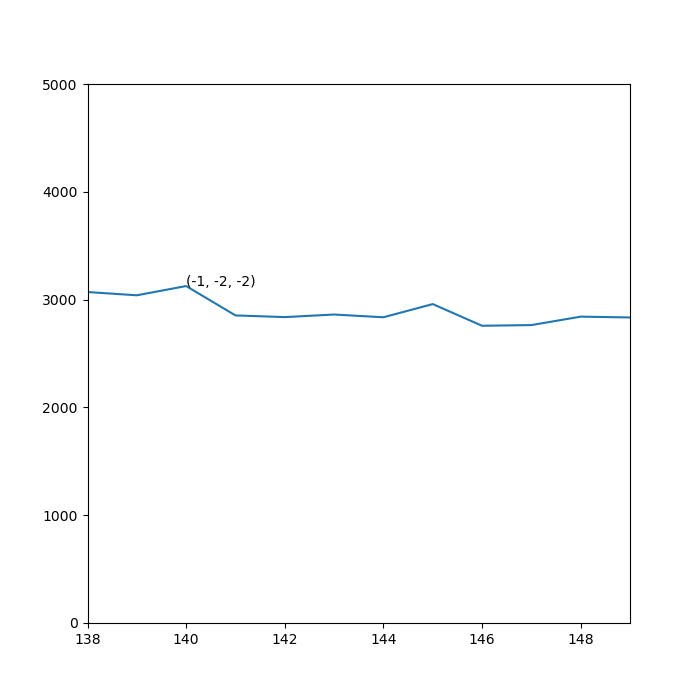

[]

In [39]:
# plot
plt.figure(figsize=(7,7))
for i in list(total_cost.keys()):
    plt.plot(total_cost[i][0])
    plt.annotate(str(i), (140,total_cost[i][0][140]),(140,total_cost[i][0][140]))
plt.axis([138,149,0,5000]) # Limit the view to this region
plt.plot()